In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import torch.optim as optim


import torch.nn as nn
import torch.nn.functional as F



import os 
import cv2
import numpy as np
from tqdm import tqdm

rebuild_data = False

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
else:
    device = torch.device("cpu")
    
#i could assign specific layers to one gpu 

torch.cuda.device_count() #but i have only one :P
    

1

In [3]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                try:
                    
                    print(label)
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    #pass
                    print(str(e))
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
        

In [4]:
if rebuild_data:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [5]:
training_data = np.load("training_data.npy", allow_pickle = True)

In [6]:
(training_data[123][0].shape) #T p(xy),d p 0 thru 2000ish, d is e_i, 

(50, 50)

In [7]:
print(training_data[123][0])

[[ 55  46  59 ... 221 151 201]
 [ 59  60  68 ... 226 166 188]
 [ 75  68  71 ... 221 178 163]
 ...
 [111 143 117 ... 101  93  98]
 [134 131 123 ...  92  96 100]
 [117 106 121 ...  88  93 102]]


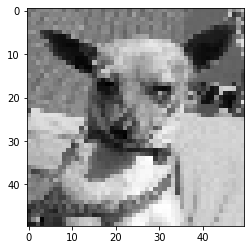

In [8]:

plt.imshow(training_data[1][0], cmap = "gray")

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x) 
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        #return x
        

In [10]:
net = Net()
#tensors on gpu interact only with tesors on the gpu
net.to(device)

torch.Size([128, 2, 2])


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [11]:
optimizer = optim.Adam(net.parameters(), lr= 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)

X.shape


torch.Size([24946, 50, 50])

In [12]:

X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
#now this is finally usable data


VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)
y.shape

2494


torch.Size([24946, 2])

In [13]:
train_X = X[:-val_size] 
train_y = y[:-val_size]

test_X = X[-val_size: ]
test_y = y[-val_size: ] #traaaaaaaaiin. test.


In [14]:
BATCH_SIZE = 1000

EPOCHS = 5

In [ ]:
def train(net):    
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE), position=0, leave = True):
            #print(i,i+BATCH_SIZE)
            batch_X = train_X[i: i + BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i: i + BATCH_SIZE]
            
            #tensors on gpu interact only with tesors on the gpu
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X) #feed in
            loss = loss_function(outputs, batch_y) #MSE calc
            loss.backward() #adjust wts
            optimizer.step() #https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step

    print(loss)
    
train(net)

In [16]:
#tensors on gpu interact only with tesors on the gpu
test_X = X[-val_size: ].to(device)
test_y = y[-val_size: ].to(device)

In [17]:
test_X[45].view(-1, 1, 50, 50).shape

torch.Size([1, 1, 50, 50])

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total,3))

In [19]:
#cannot push accuracy above 75% with more training i guess, MAYBE I AM ACTUALLY WALKING OUT OF OPTIMUM WELL

In [20]:
# I SHOULD BE COMPARING IN-SAMPLE ACCURACY VS OUT-SAMPLE ACCURACY

In [21]:
#JUST MANUALLY TESTING ON A PUG IMAGE AS AN EXERCISE

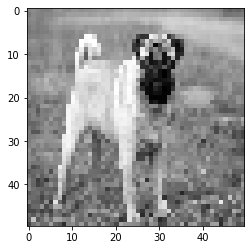

In [22]:
img = cv2.imread("pug.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (50, 50))
plt.imshow(img, cmap = "gray")

In [23]:
pugData = []
pugData.append([np.array(img), np.eye(2)[1]])
#pugImgTensor = torch.Tensor(pugData[0][0]).view(-1, 50, 50)  WRONG!!!!!!! I NEED A [1, blah] torchSize, when i'll have multiple images

In [24]:
pugImgTensor = torch.Tensor(pugData[0][0]).view(-1, 1, 50, 50)
pugImgTensor.shape

torch.Size([1, 1, 50, 50])

In [25]:
#pugLabelTensor = torch.Tensor(pugData[0][1]) WRONG!!!!!!!!!! I NEED A [1, blah] torchSize
pugLabelTensor = torch.Tensor(pugData[0][1]).view(-1,2)
pugLabelTensor.shape

torch.Size([1, 2])

In [26]:
pugImgTensor = pugImgTensor.to(device)  #NOTE THIS STEP

In [27]:
with torch.no_grad():
    pugTestOut = net(pugImgTensor)
    print(pugTestOut)

torch.Size([128, 2, 2])
tensor([[0., 1.]], device='cuda:0')
